### Imports

In [247]:
#Base
import pandas as pd
import numpy as np

#others

import itertools
import string
import re

#Visuals
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

#warnings
import warnings
warnings.filterwarnings('ignore')

In [248]:
#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

In [3]:
#nltk
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, sent_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
from nltk import WordNetLemmatizer, pos_tag

### CSV File - EDA

In [4]:
#loading csv file

df = pd.read_csv('/Users/kellyjara/Desktop/Project_4/Data/judge-1377884607_tweet_product_company.csv', 
                encoding='latin-1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
# Viewing columns and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [6]:
# Renaming column for easier callback/reference

df.rename(columns = {'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}, inplace = True)

In [7]:
#Viewing change 

df.head()

,tweet_text,emotion_in_tweet_is_directed_at,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [8]:
#checking NaN values in columns

df.isna().sum()

tweet_text                            1
emotion_in_tweet_is_directed_at    5802
emotion                               0
dtype: int64

In [9]:
# Dropping column as it is not needed for sentiment analysis

df.drop(columns = 'emotion_in_tweet_is_directed_at', inplace = True)

In [10]:
# Dropping NaN values in the df
df.dropna(axis = 0, inplace = True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  9092 non-null   object
 1   emotion     9092 non-null   object
dtypes: object(2)
memory usage: 213.1+ KB


In [12]:
df['emotion'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

In [13]:
# Dropping values that contain no emotion; Keeping only positive and negative emotions
df2 = df[df['emotion'] != "I can't tell"]
df2 = df2[df2['emotion'] != "No emotion toward brand or product"]

In [14]:
df2['emotion'].value_counts()

Positive emotion    2978
Negative emotion     570
Name: emotion, dtype: int64

In [15]:
# Creating emotion column into a numerical value
df2['target'] = df2['emotion'].astype('category')
categories = ['Positive emotion', 'Negative emotion']
df2['target'] = df2['target'].cat.reorder_categories(categories)
df2['target'] = df2['target'].cat.codes
df2['target'].value_counts()

0    2978
1     570
Name: target, dtype: int64

In [16]:
# Viewing 1st tweet in the df 
tweet_1 = df['tweet_text'].iloc[0]
tweet_1

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

<Axes: xlabel='emotion', ylabel='count'>

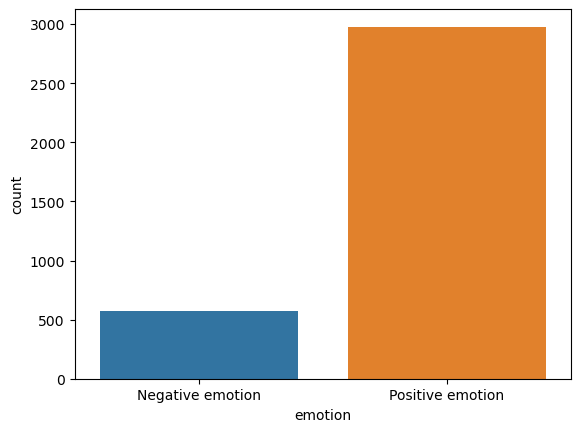

In [17]:
#Visualization of data distribution
sns.countplot(x = 'emotion', data = df2)

### Text PreProcessing 

In [18]:
def process_tweet(tweet_text, min_length):
    
    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('JJ'):
            return wordnet.ADJ
        elif nltk_tag.startswith('VB'):
            return wordnet.VERB
        elif nltk_tag.startswith('NN'):
            return wordnet.NOUN
        elif nltk_tag.startswith('RB'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    tweet_lower = tweet_text.lower()

    #remove mentions, hashtags, and urls, strip whitspace and breaks
    tweet_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", 
                         tweet_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    
    # remove stop words and punctuations 
    tweet_norm = [x for x in word_tokenize(tweet_lower) if ((x.isalpha()) & (x not in stop_words)) ]
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(tweet_norm))) 

    # rejoining lemmatized sentence 
    tweet_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
    return tweet_norm

In [19]:
df2['norm_tweet'] = df2['tweet_text'].apply(process_tweet, args = [5])
df2

,tweet_text,emotion,target,norm_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,1,iphone hr tweet dead need upgrade plugin station
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,0,know awesome app likely appreciate design also...
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,0,wait also sale
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,1,hope year festival crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,0,great stuff fri mayer google tim tech amp matt...
...,...,...,...,...
9077,@mention your PR guy just convinced me to swit...,Positive emotion,0,pr guy convince switch back iphone great coverage
9079,&quot;papyrus...sort of like the ipad&quot; - ...,Positive emotion,0,quot papyrus sort ipad quot nice lol lavelle
9080,Diller says Google TV &quot;might be run over ...,Negative emotion,1,diller say google tv quot run playstation xbox...
9085,I've always used Camera+ for my iPhone b/c it ...,Positive emotion,0,always use iphone image stabilizer mode sugges...


### Vectorizing

In [187]:
#Train-Test-Split
X = df2['norm_tweet']
y = df2['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [202]:
X_train

4115    japan apple store serve rally point massive qu...
8703                                take ipad really want
8505    well apple open temporary store downtown austi...
3961    start use android app totally killer service t...
2613        like apple store sixth street congress avenue
                              ...                        
1100    information morning apple store get build week...
955     tomlinson tx observer say apple subscription d...
5384      rt almost quot quot answer w google doc session
5927    rt google art project great virtual field trip...
2956    woot rumor apple open temporary store downtown...
Name: norm_tweet, Length: 2838, dtype: object

#### CountVectorizer

In [203]:
cv = CountVectorizer()
cv_X_train = cv.fit_transform(X_train)
cv_X_test= cv.transform(X_test)
cv.get_feature_names_out()

array(['aapl', 'abacus', 'abandon', ..., 'zoom', 'zzzs', 'åç'],
      dtype=object)

#### TfidfVectorizer

In [194]:
vec = TfidfVectorizer()

vec.fit(X_train)
X_train_vec = vec.transform(X_train)
X_test_vec = vec.transform(X_test)
 

pd.DataFrame(X_train_vec.toarray(), columns = vec.get_feature_names_out())

,aapl,abacus,abandon,aber,ability,able,abroad,absolute,absolutely,abt,...,zero,zimride,zip,zms,zombie,zomg,zone,zoom,zzzs,åç
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [145]:
len(vec.get_feature_names_out())
vec.get_feature_names_out()

array(['norm_tweet'], dtype=object)

### Topic Modeling

In [204]:
top_mod = NMF(n_components = 2)
top_mod.fit(cv_X_train)

NMF(n_components=2)

In [205]:
H = top_mod.transform(cv_X_train)
W = top_mod.components_

print("Shape of W is" + str(W.shape))
print("Shape of H is" + str(H.shape))
print("Shape of train is" + str(cv_X_train.shape))

Shape of W is(2, 3598)
Shape of H is(2838, 2)
Shape of train is(2838, 3598)


In [206]:
# 2,838 tweets in this train set
# 3,598 features

In [207]:
vec_df = pd.DataFrame(cv_X_train.toarray(), columns = cv.get_feature_names_out())
vec_df['target'] = y_train
vec_df

,aapl,abacus,abandon,aber,ability,able,abroad,absolute,absolutely,abt,...,zero,zimride,zip,zms,zombie,zomg,zone,zoom,zzzs,åç
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [208]:
vec_df['target'].value_counts()

0.0    793
1.0    142
Name: target, dtype: int64

In [209]:
vec_df.iloc[200].sort_values(ascending = False)[:10]

crowd       1.0
link        1.0
ipad        1.0
swarm       1.0
launch      1.0
poor        0.0
popup       0.0
populous    0.0
popular     0.0
pop         0.0
Name: 200, dtype: float64

### Model Eval - CtVectorizer

#### Model imports

In [246]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score

### Logistic Regression

In [244]:
from sklearn.linear_model import LogisticRegression

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       581
           1       0.82      0.31      0.45       129

    accuracy                           0.86       710
   macro avg       0.84      0.65      0.69       710
weighted avg       0.86      0.86      0.84       710



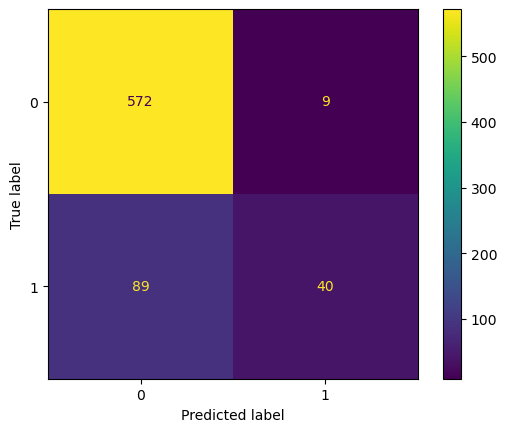

In [255]:
logreg = LogisticRegression()

logreg.fit(cv_X_train, y_train)
preds = logreg.predict(cv_X_test)

print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm).plot()

In [280]:
print(logreg.score(cv_X_train, y_train))
print(logreg.score(cv_X_test, y_test))

0.9577167019027484
0.8619718309859155


In [265]:
roc_auc_score(y_test, preds)

0.6472934929085111

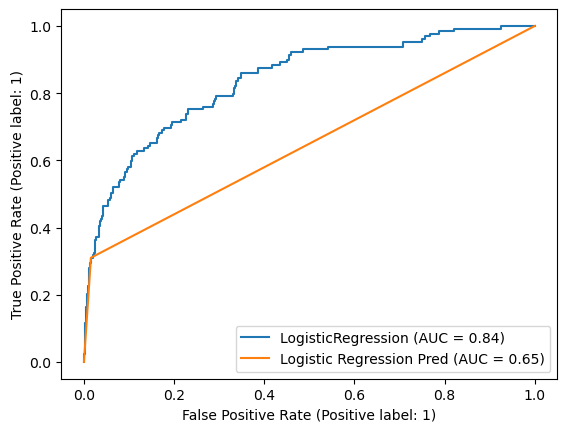

In [278]:
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(logreg, cv_X_test, y_test, ax = ax)
RocCurveDisplay.from_predictions(y_test, preds ,ax=ax,name="Logistic Regression Pred")

### Bernoulli model 

In [241]:
from sklearn.naive_bayes import BernoulliNB

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       581
           1       0.83      0.15      0.25       129

    accuracy                           0.84       710
   macro avg       0.83      0.57      0.58       710
weighted avg       0.84      0.84      0.79       710



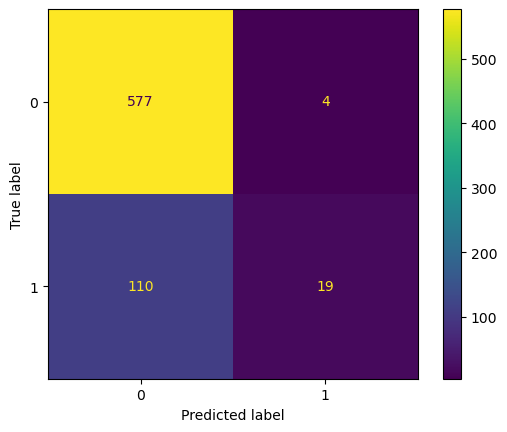

In [256]:
bn_model = BernoulliNB()
bn_model.fit(cv_X_train, y_train)
bn_pred = bn_model.predict(cv_X_test)

print(classification_report(y_test, bn_pred))

bn_cm = confusion_matrix(y_test, BN_pred)
ConfusionMatrixDisplay(bn_cm).plot()

In [281]:
print(bn_model.score(cv_X_train, y_train))
print(bn_model.score(cv_X_test, y_test))

0.9069767441860465
0.8394366197183099


In [257]:
roc_auc_score(y_test, BN_pred)

0.5702010700609749

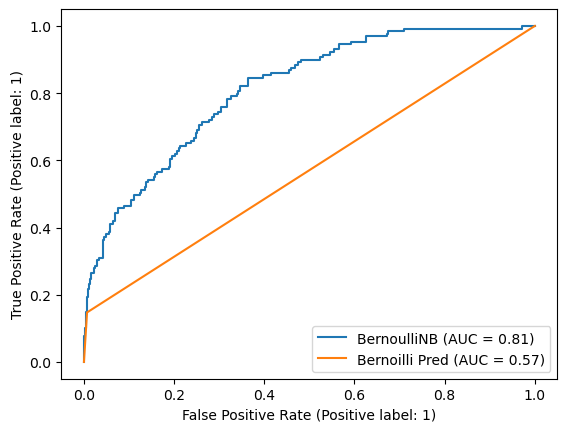

In [279]:
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(bn_model, cv_X_test, y_test, ax = ax)
RocCurveDisplay.from_predictions(y_test, BN_pred ,ax=ax,name="Bernoilli Pred")

### Random Forest

In [243]:
from sklearn.ensemble import RandomForestClassifier

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       581
           1       0.00      0.00      0.00       129

    accuracy                           0.82       710
   macro avg       0.41      0.50      0.45       710
weighted avg       0.67      0.82      0.74       710



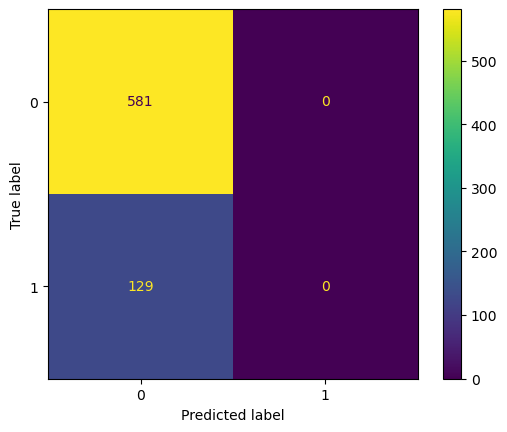

In [282]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 5)
rf.fit(cv_X_train, y_train)
rf_pred = rf.predict(cv_X_test)

print(classification_report(y_test, rf_pred))

rf_cm = confusion_matrix(y_test, rf_pred)
ConfusionMatrixDisplay(rf_cm).plot()

In [283]:
print(rf.score(cv_X_train, y_train))
print(rf.score(cv_X_test, y_test))

0.8446088794926004
0.8183098591549296


In [284]:
roc_auc_score(y_test, rf_pred)

0.5

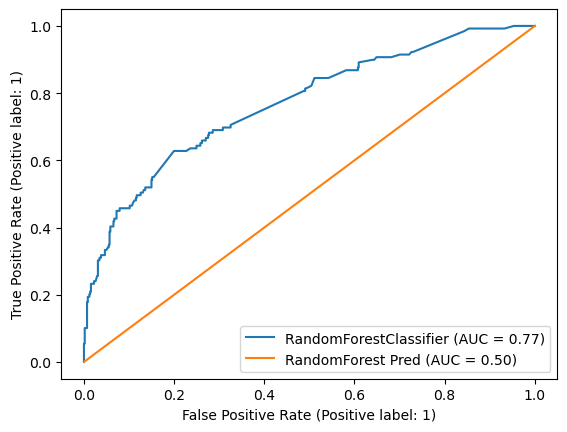

In [291]:
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(rf, cv_X_test, y_test, ax = ax)
RocCurveDisplay.from_predictions(y_test, rf_pred ,ax=ax,name="RandomForest Pred")

### Naive Bayes

In [240]:
from sklearn.naive_bayes import MultinomialNB

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       581
           1       0.75      0.29      0.42       129

    accuracy                           0.85       710
   macro avg       0.80      0.64      0.67       710
weighted avg       0.84      0.85      0.83       710



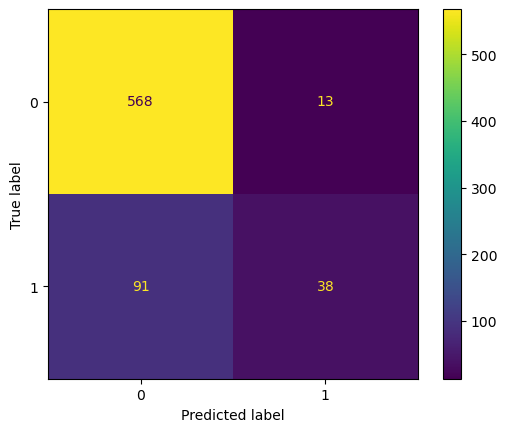

In [286]:
nb = MultinomialNB()
nb.fit(cv_X_train, y_train)
nb_pred = nb.predict(cv_X_test)

print(classification_report(y_test, nb_pred))

nb_cm = confusion_matrix(y_test, nb_pred)
ConfusionMatrixDisplay(nb_cm).plot()

In [287]:
print(nb.score(cv_X_train, y_train))
print(nb.score(cv_X_test, y_test))

0.9341085271317829
0.8535211267605634


In [288]:
roc_auc_score(y_test, nb_pred)

0.6360992141322767

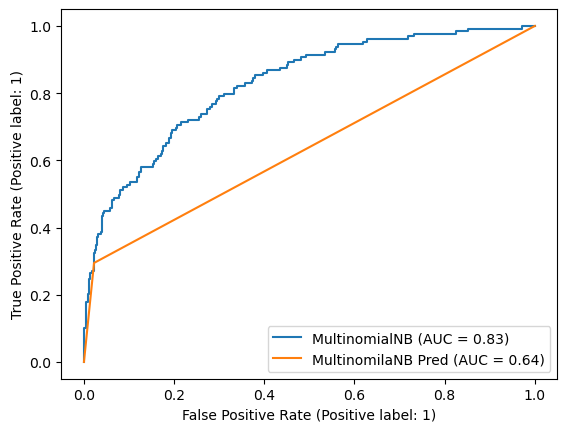

In [290]:
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(nb, cv_X_test, y_test, ax = ax)
RocCurveDisplay.from_predictions(y_test, nb_pred ,ax=ax,name="MultinomilaNB Pred")

### Compliment Naive Bayes

In [238]:
from sklearn.naive_bayes import ComplementNB

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       581
           1       0.61      0.48      0.54       129

    accuracy                           0.85       710
   macro avg       0.75      0.71      0.73       710
weighted avg       0.84      0.85      0.84       710



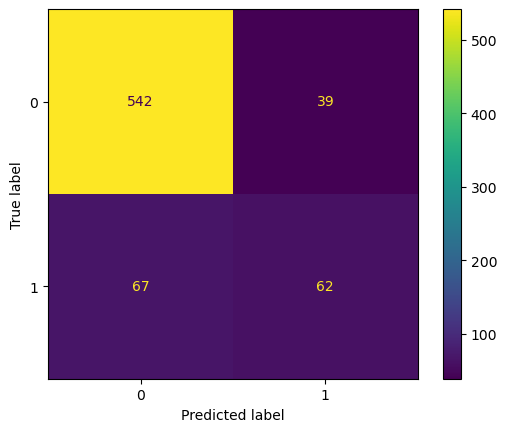

In [292]:
com_nb = ComplementNB()
com_nb.fit(cv_X_train, y_train)
com_pred = com_nb.predict(cv_X_test)

print(classification_report(y_test, com_pred))

com_cm = confusion_matrix(y_test, com_pred)
ConfusionMatrixDisplay(com_cm).plot()

In [293]:
print(com_nb.score(cv_X_train, y_train))
print(com_nb.score(cv_X_test, y_test))

0.9164904862579282
0.8507042253521127


In [294]:
roc_auc_score(y_test, com_pred)

0.7067472547999306

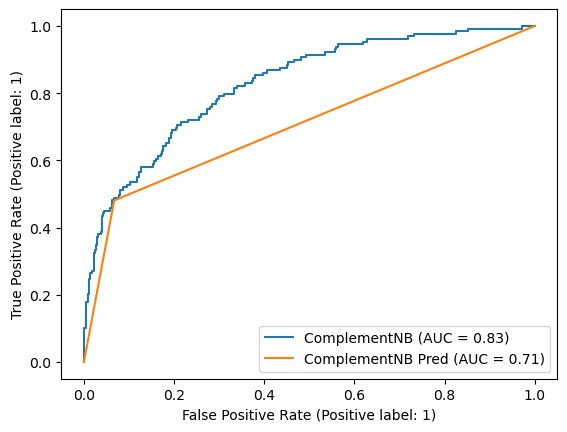

In [296]:
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(com_nb, cv_X_test, y_test, ax = ax)
RocCurveDisplay.from_predictions(y_test, com_pred ,ax=ax,name="ComplementNB Pred")